
# Determine MLD
This section reads in the CTD downcast files and identifies the 0.03 density change to calculate the MLD. THe MLD is then linearly interpolated onto the ship's track.

In [1]:
## Install the package if needed:
#install.packages('Mcomp', repos='http://cran.us.r-project.org')

## Load the relevent packages
library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x,origin="1899-12-30", tz=tz))
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

[1] 3

__Load the CTD data:__

In [2]:
ctd.path = './Raw Data/CTD/DataZoo - P1706 CTD Downcast Data.xlsx'
log.path = './Raw Data/CTD/DataZoo - P1706 CTD Cast Log.xlsx'

## Read in the data files and convert the excel time
log = read.xlsx(log.path, sheet = 'Data')
ctd = read.xlsx(ctd.path)

In [3]:
calc.mld = function(ctd.path, log.path, delta.rho = 0.1, real.time = TRUE) {
    

    
    ## this section calculates the mld for each cast
    mld = data.frame(time = 0, Lat = 0, Long = 0, mld = 0, Cast = 0)
    #mld.times = c()

    ctd = ctd[ctd$Pressure >= 10,] ## Remove shallow data since mld will be defined as > 10m

    ## Go through each cast and determine the MLD and then save that depth to a table.
    for (i in unique(ctd$Cast)){

        ## Select the relevent density profile
        l = which(ctd$Cast == i)
        rho = ctd$Sigma_00[l]
        if (all(is.na(rho))) {
            rho = ctd$Sigma_11[l]
        }

        if (length(l) > 5) { ## make sure it was a real cast (i.e. more than 10 data points)

            l.log = which(log$Cast == i)[1]  # Which entry is this cast in the ctd log?
            rho.10 = rho[ctd$Pressure[l] == 10]  # density at 10 meters depth

            ll = which.min(abs(rho - (rho.10 + delta.rho)))# What is the closest density to rho10 + 0.03?

            # Save the Data
            mld = rbind(mld, c(ctd$DateTime_GMT[l[1]], log$Lat[l.log], log$Long[l.log], ctd$Pressure[l[ll]], i) )
            #mld.times = c(mld.times, ctd$DateTime_GMT[l[1]])
        }
    }
    if (real.time) {
        mld$time = conv_excel_time(mld$time)
    }
    
    mld = mld[-1,]
    mld
}

__Run the Interpolation:__

In [4]:
## Choose a delta rho from rho.10
#delta.rho = 0.03
#delta.rho = 0.05
delta.rho = 0.1
#delta.rho = 0.125

mld = calc.mld(ctd, log, delta.rho)

---
# Save the results

In [41]:
save(mld, file=paste0('./RStates/mld-', delta.rho ,'.rdata'))

---
# Plots

In [42]:
#par(mfrow=c(2,2))
#hist(mld$mld, breaks = 20)

In [6]:
plot.cast = function(ctd, mld, target.time, d.max = 100, save.plots = FALSE, dir = 'Output/') {
    ctd$DateTime_GMT = conv_excel_time(ctd$DateTime_GMT)
    
    cast = ctd$Cast[which.min(as.numeric(difftime(ctd$DateTime_GMT, target.time, units='hours'))^2)]
    name = paste("Cast -", cast)


    if (save.plots) {
        pdf(paste0(dir, 'CTD Profile + MLD-', name, '.pdf'))
    }
    par(mfrow=c(2,2))

    l = which(ctd$Cast == cast)
    plot(ctd$T190C[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Temperature', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

    plot(ctd$OxymicroM[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='uM Oxygen', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

    plot(ctd$Sigma_11[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Density', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)

    plot(ctd$Fluor[l], ctd$Pressure[l], pch=20, ylim=c(d.max,0), ylab='Depth(m)', xlab='Fluorometer', main=name)
    lines(c(0,1e3), rep(mld$mld[which(mld$Cast == cast)], 2), lty=2)
    
    if (save.plots) {
        dev.off()
    }
}

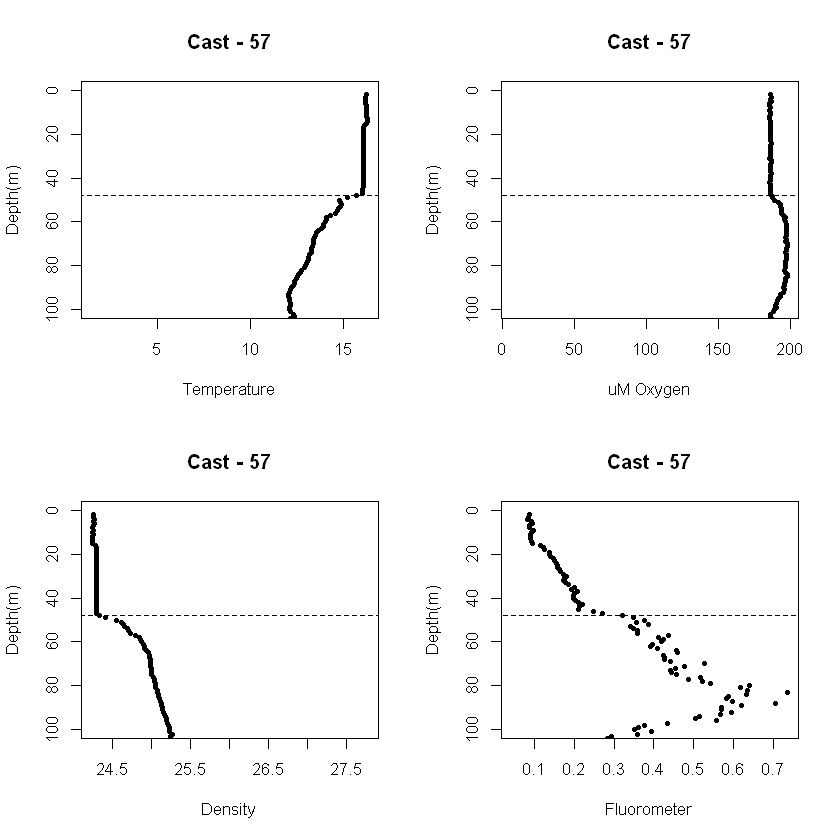

In [7]:
#target.time = strptime("2017/06/18 05:15", format="%Y/%m/%d %H:%M", tz='UTC')
target.time = strptime("2017/06/22 20:05", format="%Y/%m/%d %H:%M", tz='UTC')
#target.time = strptime("2017/06/18 05:15", format="%Y/%m/%d %H:%M", tz='UTC')

plot.cast(ctd, mld, target.time, save.plots = FALSE)

In [11]:
for (i in unique(log$DateTime_GMT)) {
    try({plot.cast(ctd, mld, conv_excel_time(i), save.plots = TRUE, dir = 'Output/CTD/')})
}

Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in 

In [9]:
log$DateTime_GMT[1:10]

[1] 42887.89 42888.67 42892.93 42894.06 42894.13 42894.18 42894.24 42894.29
 [9] 42894.36 42894.43